# Final Year Project

## Procedure
1. Choose variables.
2. Modify data to analyze and split data into test one, and train one.
3. Examine the order and fit the model to the data and estimate the period of test data.
4. Evaluate the model and its estimates.
5. Retrain the model using all the data and estimate the future.
6. Test causal inference between variables.


## Variables to use

1. Industrial Production Index (IPI)
2. the ratio of trade to GDP (TRADE)
3. the ratio of government final consumption expenditure (GCE)
4. Bank credit to private sector (BCP)
5. the ration of private sector's domestic credit to GDP (GDPP)
6. the ratio of M3 to GDP (GDPM)
7. the ratio of domestic savings to GDP (GDS)
8. interest rates New!
9. turnover ratio
10. the ratio of stock market total value traded to GDP (SMT)

## Database to check

FREDMD:id 80 : S&P 500

World Bank’s World Development indicators, Financial Structure Databaseなどもデータ入手先の候補

データソースは International Financial Statistics, South Africa Reserve Bank, Johannesburg Stock Exchange　ーUmar


 データ分析する期間として，一応アベノミクス（2013/6/14~2020/8/26）の期間がメイン．trainは一応


import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw,pacf_ols
#ARモデル
from statsmodels.tsa.ar_model import AR,ARResults
#ARIMAモデル
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from pandas.plotting import lag_plot
import math
from statsmodels.stats.stattools import durbin_watson
# Ignore harmless warning
import warnings
warnings.filterwarnings("ignore")

In [19]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw,pacf_ols
#ARモデル
from statsmodels.tsa.ar_model import AR,ARResults
#ARIMAモデル
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from pandas.plotting import lag_plot
import math
from statsmodels.stats.stattools import durbin_watson
# Ignore harmless warning
import warnings
warnings.filterwarnings("ignore")

In [94]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series, title = ""):
    """
    時系列を投入し，オプションでタイトルを決めると，ADFレポートを返す
    """
    print(f"Augumented Dickey-Fuller Test:{title}")
    result = adfuller(series.dropna(),autolag = "AIC") # .dropna() handles differenced data
    labels = ["ADS test statistic", "p-value", "# lags used", "# observations"] # # はnumberの略
    out = pd.Series(result[0:4],index = labels)

    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out.to_string()) # .to_string() は "dtype:float64"を取り除く

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    return result[1]

#ここからadfなどもして前期との相関を見てくれる関数を作る
def plot_series(series, figsize = (9,6), title = "", model = "add"):
    season = seasonal_decompose(series,model = model)
    season.plot();

def plot_property(series, title = "", num = 30):
    lag_plot(series)
    plot_acf(series,lags = num, title = f"{title} ACF")
    plot_pacf(series,lags = num,title = f"{title} PACF")


def all_plot(data, title = "", figsize = (12,9),model = "add",series = False, acf = False ,num = 30,col = 2):
    """
    全てのデータをプロットする．オプションでacf, pacfもプロットできるはず
    """
    columns = data.columns
    fig, axes = plt.subplots(nrows= math.ceil(len(columns)/col), ncols=col, dpi=120, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i <= len(columns)-1:
            df = data[data.columns[i]]
            ax.plot(df, linewidth=1)
            ax.set_title(data.columns[i])
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')
            ax.spines["top"].set_alpha(0)
            ax.tick_params(labelsize=6)
            plt.subplots_adjust(hspace=0.6)
    for column in columns:
        if series == True:
            plot_series(data[column],title = column, model = model,figsize = figsize)
        if acf == True:
            plot_property(data[column], title = column, num = num)

#何個のdiffを取るべきかを明らかにする
def auto_adf(data):
    num = len(data.columns)
    #num_dic shows how many times the series need to be differenced
    num_dic = {}
    for x in range(num):
        result = adf_test(data.iloc[:,x])
        diff_num = 0
        series = data.iloc[:,x].diff()
        while result > 0.05:
            result = adf_test(series)
            series = series.diff()
            diff_num = diff_num + 1
        print(f"{data.columns[x]} needs {diff_num} times difference to obtain stationary")
        num_dic[data.columns[x]] = diff_num
        print("--------------------------------")
    return num_dic

#diffを行う回数分差分を取り，それを再びデータとして加える．
def differencing_data(data):
    #make a new data frame, which requires the same index of the original data
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    #辞書型のデータを取る
    dic_data = auto_adf(data)
    num = len(data.columns)
    for x in range(num):
        series = data.iloc[:,x]
        diff_num = dic_data[data.columns[x]]
        diff_times = 0
        while diff_times != diff_num:
            series = series.diff()
            diff_times = diff_times + 1
        #add series to the new_data
        new_data[f"{data.columns[x]}_{diff_num}"] = series
    return new_data.dropna()


#予測の関数を作る,　蜜柑

def ARforecast(original_data,num = 5,order = 6):
    """
    You need to input stationary data.
    The function automatically forecast with AR model.
    You can input DataFrame.
    The function returns the forecasts of variables and their lags in AR models as a dictionary.
    """
    data = differencing_data(original_data).dropna()
    train = data[:-num]
    test = data[-num:]    
    lags = {}
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(index = idx,columns = data.columns)
    for key in data.columns:
        result_AIC = {}
        result_BIC = {}
        for i in range(1,order):
            model = AR(train[[key]])
            result = model.fit(i)
            result_AIC[i] = result.aic
            result_BIC[i] = result.bic
        min_AIC = min(result_AIC, key=result_AIC.get)
        min_BIC = min(result_BIC, key = result_BIC.get)
        md = AR(train[key])
        result = md.fit(min_AIC)
        print(result.summary())
        lag_order = result.k_ar
        lags[key] = lag_order
        start = len(train)
        end = len(train) + len(test) - 1
        forecast = result.predict(start = start ,end = end)
        idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
        df_forecast[key] = pd.DataFrame(forecast)
    return df_forecast,lags # return is two variables

#VARforecast関数に投入するtrainデータにはnot positive definiteの列を加えてはならない
#------Q. not positive definiteとなる列をどのように処理するのか？？--------
def VARforecast(data,num = 5,order = 7,orth = True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order+3)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    # Durbin_watsonを組み込んだ
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson Test is ended")
    return df_forecast.dropna()

#granger causalityを調べる関数が必要である．
# original data でgrnger causalityを調べたとして，それはdifferenced dataに対しても有効になるのか？
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test',set_p_value =0.05, verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    maxlag = 10
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            #p_values = [test_result[i+1][0][test][1] for i in range(maxlag)]
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            if min_p_value < set_p_value or min_p_value == 1:
                df.loc[r, c] = min_p_value
            else:
                df.loc[r, c] = False
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#共和分のテスト
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary_
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


#二つのデータをプロットして比較してくれる関数
def compare_plot(series1,series2,size = (12,6),title1 = "", title2 = "", legend = True, tight = True):
    """
    二つのデータを同時にプロット
    Plot two data simultaneously
    """
    ax = series1.plot(figsize = size, legend = legend, title = title1)
    ax.autoscale(axis = "x", tight = tight)
    dx = series2.plot(figsize = size, legend = legend, title = title1)
    dx.autoscale(axis = "x", tight = tight)

#基のデータに戻していくプロセスを行う
def reverse_data(original_data, num = 5, order = 7,orth=True):
    """
    VARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast = VARforecast(original_data,num = num,order = order,orth=orth)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        if column[:6] == "NIKKEI" or column[:6] == "Nikkei":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
    return new_data.dropna()

def ar_reverse_data(original_data, num = 5, order = 7):
    """
    ARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast,lags = ARforecast(original_data,num = num,order = order)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        if column[:10] == "NIKKEI_log" or column[:10] == "Nikkei_log":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
    return new_data.dropna(),lags

def VAR_AR_plot_evaluation(data,col = 2,num = 5,order = 7,orth= True):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse_vr = reverse_data(data, num = num,order = order,orth = orth)
    print("reverse_data is executed")
    reverse_ar,lag = ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    return lag

#プロットして比較する．
def FvsA_plot(data,col = 2,num = 5,order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse = reverse_data(data, num = num,order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)

# Evaluate関数
#予測するための道具を出す．
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def forecast_data(data,col = 2, num = 5, order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = reverse_data(data,num = num,order=order)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")

def Durbin_Watson(data,num = 5,order = 7):
    """
    Durbin_Watson検定を行う．その際には，differencingしたデータでmin AICとなるモデルを選択して当てはめる．
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    
        
## Durbing Watsonの関数を作る
# model = VAR(df_differenced)
# model_fitted = model.fit(4)
# out = durbin_watson(model_fitted.resid)
# for col, val in zip(df.columns, out):
#     print(adjust(col), ':', round(val, 2))

In [ ]:
# differencingしないパターンでの関数を作成した
# nodiffではreverseも必要ない
def VARforecast_nodiff(data,num = 5,order = 7,orth= True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson test is ended")
    print("-------------------------------")
    return df_forecast

def VAR_AR_plot_evaluation_nodiff(data,col = 2,num = 5,order = 7,orth=True):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse_vr = VARforecast_nodiff(data, num = num,order = order,orth=orth)
    print("reverse_data is executed")
    reverse_ar,lag = ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    #return lag

def FvsA_plot_nodiff(data,col = 2,num = 5):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    """
    reverse = VARforecast_nodiff(data, num = num)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax)
        test[col][-num:].plot(legend= True, ax=ax).autoscale(axis='x',tight=True);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} Forecast",f"{col} Actual"])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)


def forecast_data_nodiff(data,col = 2, num = 5):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = VARforecast_nodiff(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        
# no_diffの場合
# def Durbin_Watson_nodiff(data,num = 5,order = 7):
#     """
#     ダービンワトソン検定をdifferencingなしで行う．
#     """
#     use_data= data.dropna()
#     train = use_data[:-num]
#     test = use_data[-num:]
#     result_AIC = {}
#     result_BIC = {}
#     for i in range(order):
#     #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
#         model = VAR(train)
#         result = model.fit(i)
#         result_AIC[i] = result.aic
#         result_BIC[i] = result.bic
#     min_AIC = min(result_AIC, key=result_AIC.get)
#     min_BIC = min(result_BIC, key = result_BIC.get)
#     result = model.fit(min_AIC)
#     out = durbin_watson(result.resid)
#     def adjust(val, length= 6): return str(val).ljust(length)
#     for col, val in zip(use_data.columns, out):
#         print(adjust(col), ':', round(val, 2))
# Durbin_Watson_nodiff(USA.drop("GCE",axis = 1).drop("RIR",axis = 1).drop("Turnover_Ratio",axis = 1).drop("TRADE",axis = 1).drop("Broad_money",axis = 1).drop("BCP",axis = 1))
# Durbin_Watson_nodiff(USA.drop("GCE",axis = 1).drop("RIR",axis = 1).drop("Turnover_Ratio",axis = 1).drop("TRADE",axis = 1).drop("Broad_money",axis = 1).drop("BCP",axis = 1))

In [92]:
#TOPIXの自己回帰を調べていく
Japan = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/Japan/japan.csv",parse_dates = True, index_col = 0, header = 0)
Japan.index.freq = "YS"
#,encoding="shift-jis")

Japan["Working_People(%)"] = Japan["Working_People(million)"].dropna().pct_change()
Japan["Nikkei_log_diff"] = Japan["NIKKEI"].apply(np.log).diff()
print(Japan.isnull().sum())
Japan.head()

NIKKEI                                                          8
GDP growth (annual %)                                           2
General government final consumption expenditure (% of GDP)    12
Gross domestic savings (% of GDP)                              12
Domestic credit to private sector (% of GDP)                   11
Stocks traded, total value (% of GDP)                          16
Trade (% of GDP)                                               12
Real interest rate (%)                                         36
Deposit interest rate (%)                                      34
Domestic credit to private sector by banks (% of GDP)           1
Broad money (% of GDP)                                          1
Stocks traded, turnover ratio of domestic shares (%)           16
Stocks traded, total value (% of GDP).1                        16
Urban population growth (annual %)                              2
Rural population growth (annual %)                              2
Population

,NIKKEI,GDP growth (annual %),General government final consumption expenditure (% of GDP),Gross domestic savings (% of GDP),Domestic credit to private sector (% of GDP),"Stocks traded, total value (% of GDP)",Trade (% of GDP),Real interest rate (%),Deposit interest rate (%),Domestic credit to private sector by banks (% of GDP),...,"Stocks traded, total value (% of GDP).1",Urban population growth (annual %),Rural population growth (annual %),"Population ages 15-64, total",Population growth (annual %),"Population, total",Gross domestic income (constant LCU),Gross domestic savings (% of GDP).1,Gross domestic savings (current LCU),Nikkei_log_diff
series,,,,,,,,,,,,,,,,,,,,,
1960-01-01,869.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.311208,...,NaN,NaN,NaN,59307022.0,NaN,92500572.0,NaN,NaN,NaN,NaN
1961-01-01,1366.74,12.043536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.891148,...,NaN,4.082468,0.010717,61581778.0,2.606188,94943000.0,NaN,NaN,NaN,0.452449
1962-01-01,1425.30,8.908973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.317415,...,NaN,2.371446,-1.703945,62947200.0,0.931995,95832000.0,NaN,NaN,NaN,0.041954
1963-01-01,1418.25,8.473642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.688847,...,NaN,2.419807,-1.657461,64412663.0,1.017430,96812000.0,NaN,NaN,NaN,-0.004959
1964-01-01,1204.40,11.676708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.774318,...,NaN,2.407009,-1.670127,65850744.0,1.041944,97826000.0,NaN,NaN,NaN,-0.163442


In [30]:
df_japan = differencing_data(Japan.drop("Real interest rate (%)",axis = 1).drop("Deposit interest rate (%)",axis = 1).dropna())
data_matrix = grangers_causation_matrix(df_japan.dropna(),variables = df_japan.columns)

Augumented Dickey-Fuller Test:
ADS test statistic      -1.950189
p-value                  0.308831
# lags used              0.000000
# observations          37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic     -5.703352e+00
p-value                 7.586307e-07
# lags used             0.000000e+00
# observations          3.600000e+01
Critical Value (1%)    -3.626652e+00
Critical Value (5%)    -2.945951e+00
Critical Value (10%)   -2.611671e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
NIKKEI needs 1 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -3.393833
p-value                  0.011171
# lags used              

In [32]:
data_matrix

,NIKKEI_1_x,GDP growth (annual %)_0_x,General government final consumption expenditure (% of GDP)_1_x,Gross domestic savings (% of GDP)_1_x,Domestic credit to private sector (% of GDP)_1_x,"Stocks traded, total value (% of GDP)_1_x",Trade (% of GDP)_1_x,Domestic credit to private sector by banks (% of GDP)_1_x,Broad money (% of GDP)_1_x,"Stocks traded, turnover ratio of domestic shares (%)_0_x","Stocks traded, total value (% of GDP).1_1_x",Urban population growth (annual %)_1_x,Rural population growth (annual %)_1_x,"Population ages 15-64, total_0_x",Population growth (annual %)_0_x,"Population, total_0_x",Gross domestic income (constant LCU)_1_x,Gross domestic savings (% of GDP).1_1_x,Gross domestic savings (current LCU)_1_x,Nikkei_log_diff_0_x
NIKKEI_1_y,1,False,0.0000,0.0001,0.0048,0.0000,0,False,False,0.0240,0.0000,False,False,0.0001,0.0039,False,0.0,0.0001,False,0.04
GDP growth (annual %)_0_y,0,1,0.0000,0.0087,0.0000,0.0000,0,0,0,0.0000,0.0000,0,0,0.0000,0,0,0.0,0.0087,0,0.0003
General government final consumption expenditure (% of GDP)_1_y,0,0,1.0000,0.0407,0.0000,0.0000,0,0,0,0.0000,0.0000,0,0,0.0005,0,0,0.0,0.0407,0,0
Gross domestic savings (% of GDP)_1_y,0,0.0223,0.0000,1.0000,0.0000,0.0000,0,0,0,0.0000,0.0000,0,0.0002,0.0000,0,0,0.0,1.0000,0,0
Domestic credit to private sector (% of GDP)_1_y,0,0,0.0000,0.0000,1.0000,0.0001,0.039,0.0023,0,0.0000,0.0001,0.0009,0.027,0.0000,0,0,0.0,0.0000,0,0
"Stocks traded, total value (% of GDP)_1_y",0.0004,0,0.0000,0.0000,0.0000,1.0000,0,0.0001,0,0.0000,1.0000,0,0,0.0000,False,0.0166,0.0,0.0000,0.0003,0
Trade (% of GDP)_1_y,0,0,0.0031,0.0010,0.0000,0.0000,1,0,0,0.0000,0.0000,0,0,0.0001,0,0,0.0,0.0010,0,0
Domestic credit to private sector by banks (% of GDP)_1_y,0,0,0.0000,0.0000,0.0000,0.0021,False,1,0,0.0000,0.0021,0,False,0.0000,0,0,0.0,0.0000,0,0
Broad money (% of GDP)_1_y,0,0,0.0000,0.0000,0.0000,0.0059,False,0,1,0.0000,0.0059,0,0.0015,0.0000,0,0,0.0,0.0000,0,0
"Stocks traded, turnover ratio of domestic shares (%)_0_y",0,0,0.0000,0.0000,0.0000,0.0000,0,0,0,1.0000,0.0000,0,0,0.0000,0,0,0.0,0.0000,0,0


In [ ]:
all_plot(Japan.drop("Real interest rate (%)",axis = 1).drop("Deposit interest rate (%)",axis = 1).dropna())

In [28]:
df_japan.columns

Index(['NIKKEI_1', 'GDP growth (annual %)_0',
       'General government final consumption expenditure (% of GDP)_1',
       'Gross domestic savings (% of GDP)_1',
       'Domestic credit to private sector (% of GDP)_1',
       'Stocks traded, total value (% of GDP)_1', 'Trade (% of GDP)_1',
       'Domestic credit to private sector by banks (% of GDP)_1',
       'Broad money (% of GDP)_1',
       'Stocks traded, turnover ratio of domestic shares (%)_0',
       'Stocks traded, total value (% of GDP).1_1',
       'Urban population growth (annual %)_1',
       'Rural population growth (annual %)_1',
       'Population ages 15-64, total_0', 'Population growth (annual %)_0',
       'Population, total_0', 'Gross domestic income (constant LCU)_1',
       'Gross domestic savings (% of GDP).1_1',
       'Gross domestic savings (current LCU)_1', 'Nikkei_log_diff_0'],
      dtype='object')

In [57]:
selected_variables = []
for idx, val in zip(data_matrix.loc["Nikkei_log_diff_0_y"].index,data_matrix.loc["Nikkei_log_diff_0_y"].values):
    if val != False and yval != False:
        selected_variables.append(idx[:-4])
print(selected_variables)

['GDP growth (annual %)', 'Trade (% of GDP)', 'Domestic credit to private sector by banks (% of GDP)', 'Stocks traded, turnover ratio of domestic shares (%)', 'Urban population growth (annual %)', 'Population, total', 'Nikkei_log_diff']


Augumented Dickey-Fuller Test:
ADS test statistic      -3.827001
p-value                  0.002643
# lags used              9.000000
# observations          42.000000
Critical Value (1%)     -3.596636
Critical Value (5%)     -2.933297
Critical Value (10%)    -2.604991
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Population, total needs 0 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -1.756384
p-value                  0.402321
# lags used              1.000000
# observations          50.000000
Critical Value (1%)     -3.568486
Critical Value (5%)     -2.921360
Critical Value (10%)    -2.598662
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -5.563230
p-value                  0.000002
# lags used              0.000000
#

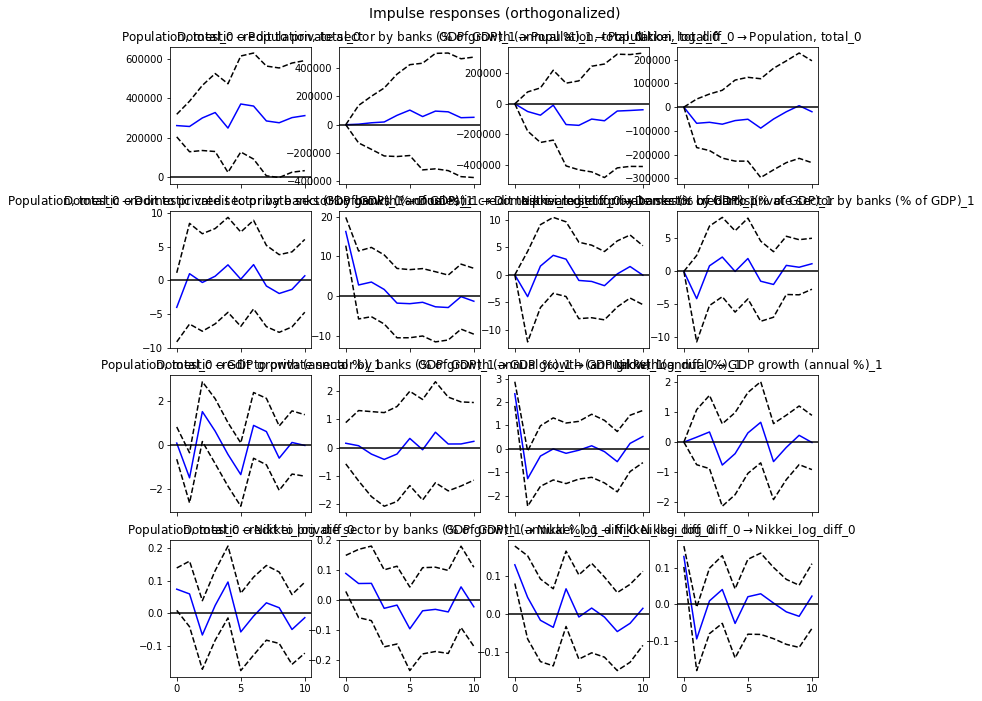

The function plots the Forecast Error Variance Decomposition
FEVD for Population, total_0
     Population, total_0  Domestic credit to private sector by banks (% of GDP)_1  GDP growth (annual %)_1  Nikkei_log_diff_0
0               1.000000                                                 0.000000                 0.000000           0.000000
1               0.948827                                                 0.000106                 0.017993           0.033074
2               0.929117                                                 0.000837                 0.033619           0.036426
3               0.935735                                                 0.001642                 0.023116           0.039507
4               0.889243                                                 0.011332                 0.060457           0.038968

FEVD for Domestic credit to private sector by banks (% of GDP)_1
     Population, total_0  Domestic credit to private sector by banks (% of GDP)_1  GDP g

{'Population, total_0': 6,
 'Domestic credit to private sector by banks (% of GDP)_1': 1,
 'GDP growth (annual %)_1': 4,
 'Nikkei_log_diff_0': 1}

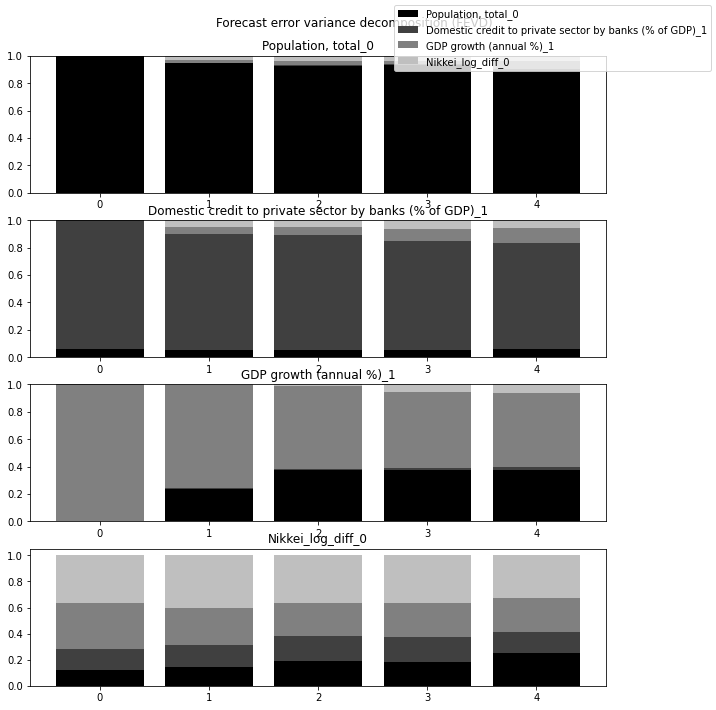

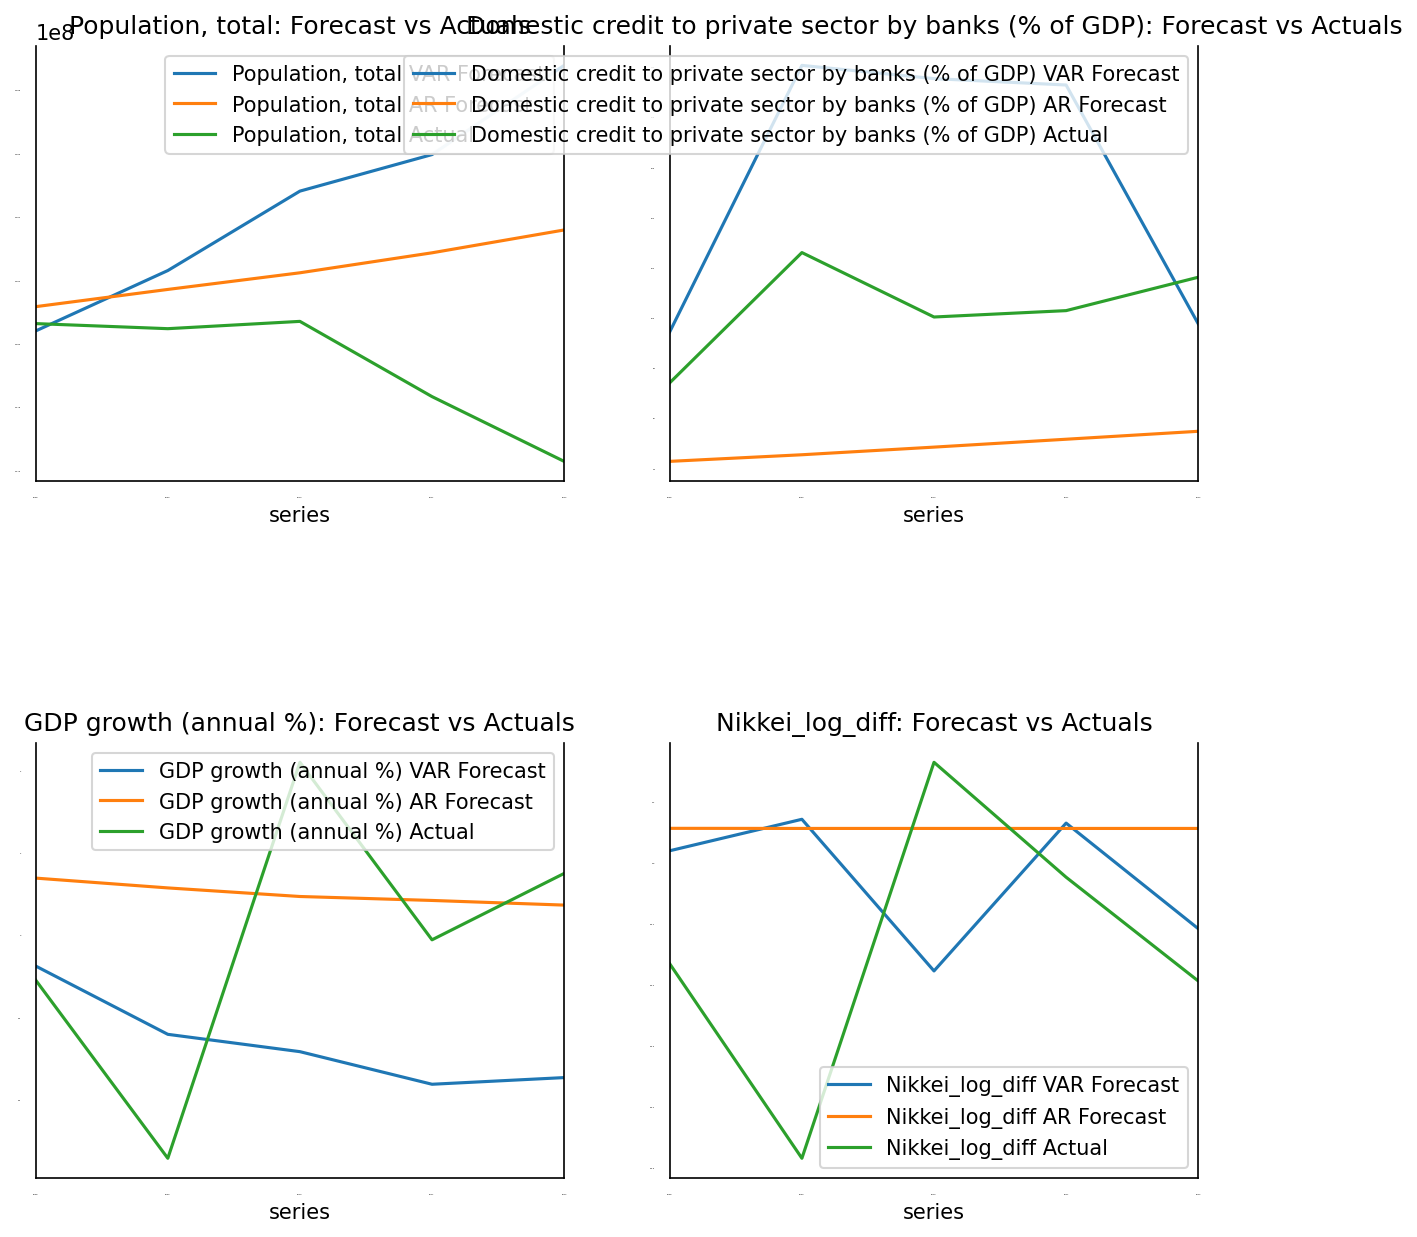

In [96]:
VAR_AR_plot_evaluation(Japan[["Population, total","Domestic credit to private sector by banks (% of GDP)","GDP growth (annual %)","Nikkei_log_diff"]].dropna())

In [95]:
ar_reverse_data(df_japan[["Nikkei_log_diff_0"]])

Augumented Dickey-Fuller Test:
ADS test statistic      -5.105814
p-value                  0.000014
# lags used              0.000000
# observations          36.000000
Critical Value (1%)     -3.626652
Critical Value (5%)     -2.945951
Critical Value (10%)    -2.611671
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Nikkei_log_diff_0 needs 0 times difference to obtain stationary
--------------------------------
                               AR Model Results                               
Dep. Variable:                      N  -                  i                  k
Model:                          AR(1)   Log Likelihood                   4.385
Method:                          cmle   S.D. of innovations              0.210
Date:                Tue, 08 Dec 2020   AIC                             -2.927
Time:                        22:10:23   BIC                             -2.788
Sample:                    01-01-1976   HQIC     

(            Nikkei_log_diff_0_0_reversed_0  Nikkei_log_diff_0_0
 2008-01-01                        0.045695             1.110228
 2009-01-01                        0.044042             1.160218
 2010-01-01                        0.043835             1.212208
 2011-01-01                        0.043809             1.266494
 2012-01-01                        0.043806             1.323207,
 {'Nikkei_log_diff_0_0': 1})

Augumented Dickey-Fuller Test:
ADS test statistic      -5.063930
p-value                  0.000017
# lags used              0.000000
# observations          36.000000
Critical Value (1%)     -3.626652
Critical Value (5%)     -2.945951
Critical Value (10%)    -2.611671
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Gross domestic savings (% of GDP)_1 needs 0 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -3.385958
p-value                  0.011447
# lags used              0.000000
# observations          36.000000
Critical Value (1%)     -3.626652
Critical Value (5%)     -2.945951
Critical Value (10%)    -2.611671
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
GDP growth (annual %)_0 needs 0 times difference to obtain stationary
--------------------------------
Augumented Dickey-Full

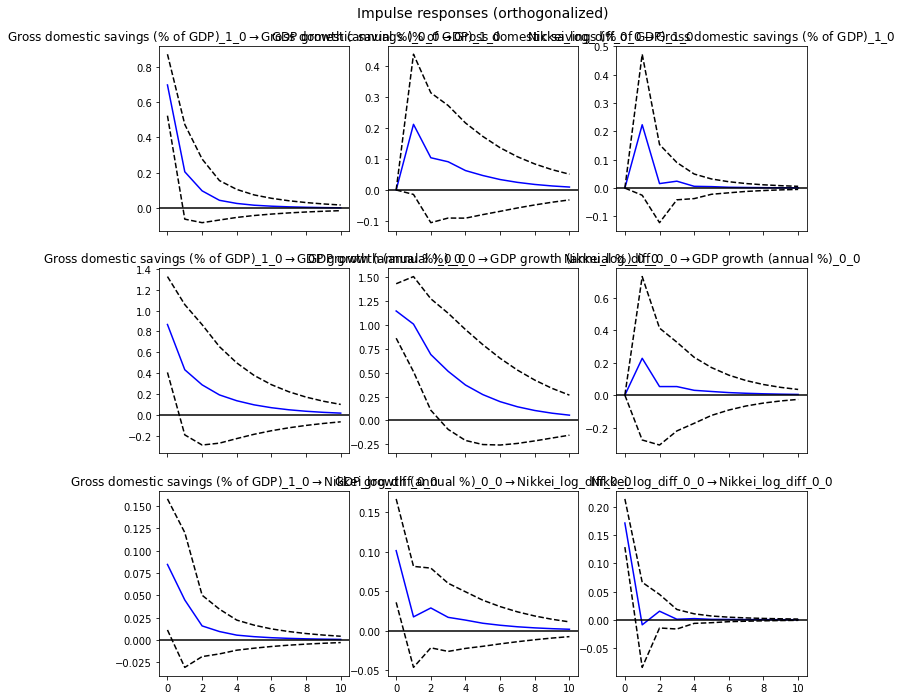

The function plots the Forecast Error Variance Decomposition
FEVD for Gross domestic savings (% of GDP)_1_0
     Gross domestic savings (% of GDP)_1_0  GDP growth (annual %)_0_0  Nikkei_log_diff_0_0
0                                 1.000000                   0.000000             0.000000
1                                 0.847985                   0.071775             0.080240
2                                 0.835783                   0.086189             0.078028
3                                 0.825020                   0.097352             0.077627
4                                 0.820292                   0.102581             0.077127

FEVD for GDP growth (annual %)_0_0
     Gross domestic savings (% of GDP)_1_0  GDP growth (annual %)_0_0  Nikkei_log_diff_0_0
0                                 0.363232                   0.636768             0.000000
1                                 0.282394                   0.702089             0.015517
2                                 0.2

{'Gross domestic savings (% of GDP)_1_0': 1,
 'GDP growth (annual %)_0_0': 1,
 'Nikkei_log_diff_0_0': 1}

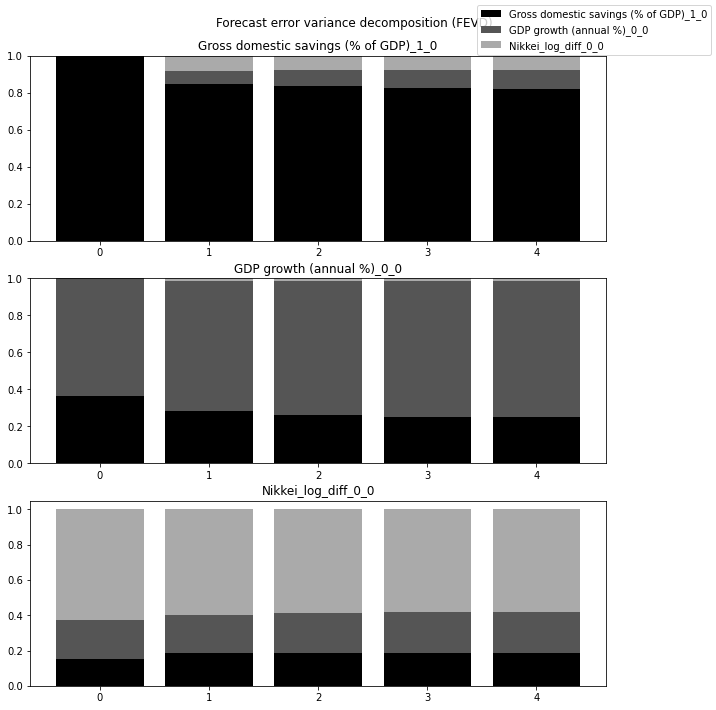

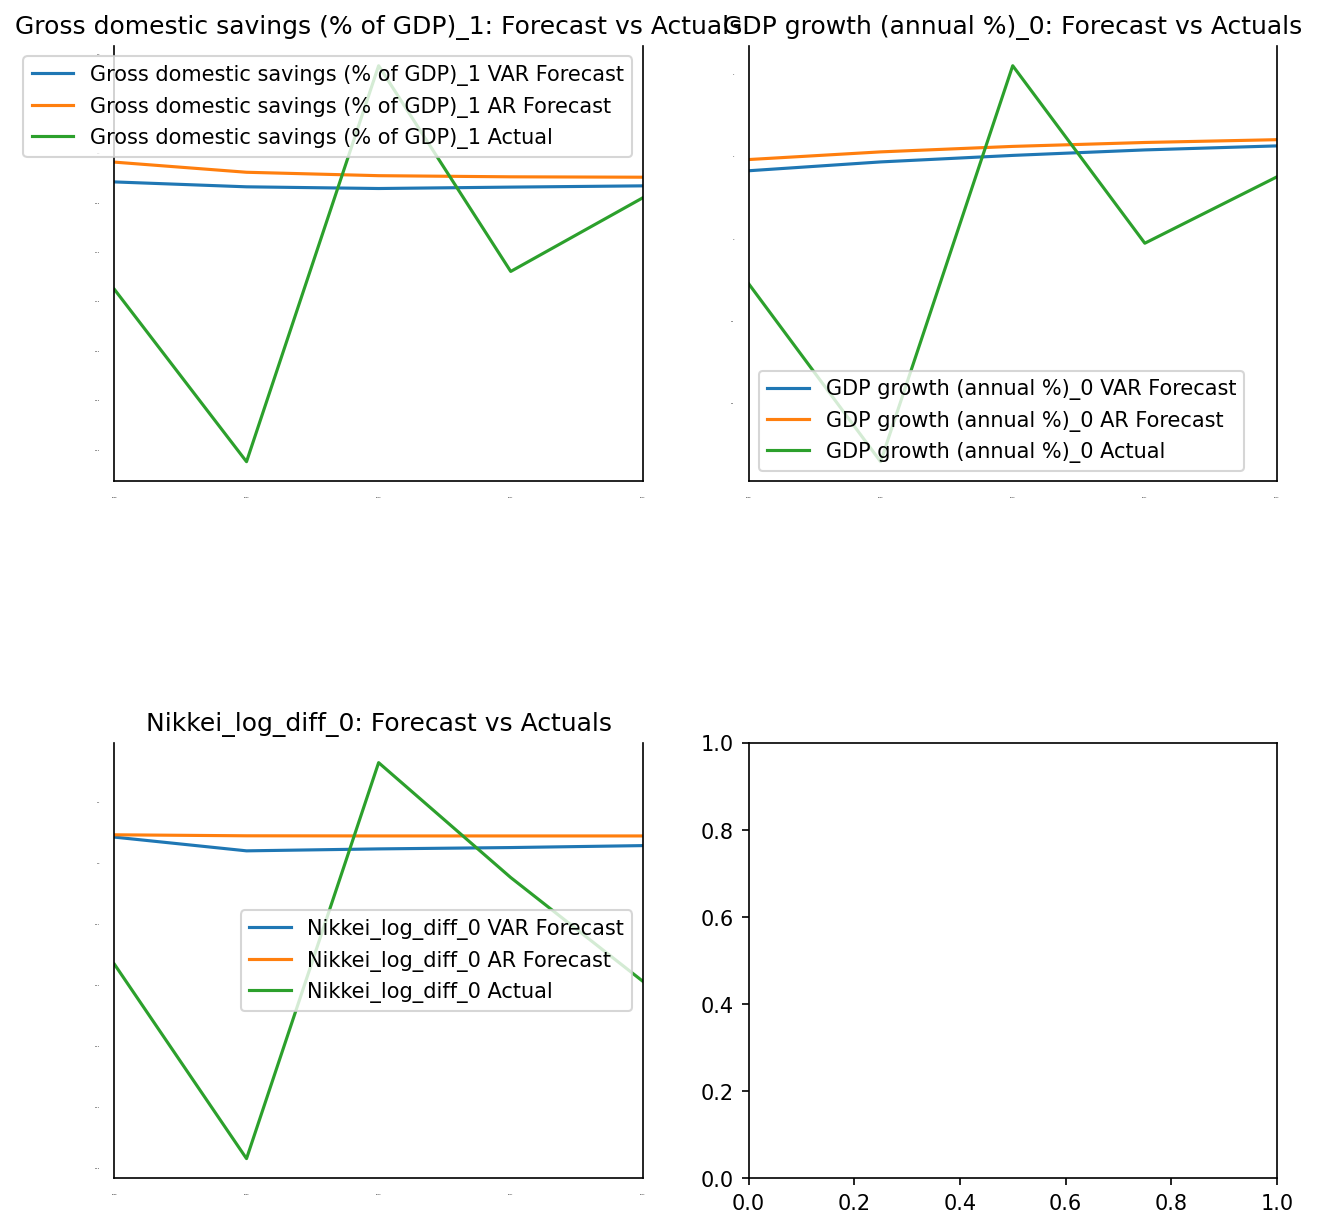

In [100]:
kouho = ["Gross domestic savings (% of GDP)_1","GDP growth (annual %)_0","Nikkei_log_diff_0"]
#"Population ages 15-64, total_0",
#cointegration_test(df_japan[["Gross domestic savings (% of GDP)_1","GDP_growth","Population ages 15-64, total","NIKKEI"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation(df_japan[kouho].dropna())

In [97]:
kouho = ["Gross domestic savings (% of GDP)_1","GDP growth (annual %)","Working_People(million)","Nikkei_log_diff_0"]
#cointegration_test(df_japan[["Gross domestic savings (% of GDP)_1","GDP_growth","Working_People(million)","NIKKEI"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation(df_japan[kouho].dropna())
#VAR_AR_plot_evaluation_nodiff(USA[["S_P500","GDP_growth","GCE","GDS"]].dropna())

KeyError: "['Working_People(million)', 'GDP growth (annual %)'] not in index"